# A Classification Neural Network Designed for Multiclass Pose Detection with Pytorch and Scklearn

## In Developement

# Preprocessing data

In [1]:
import pandas as pd
import numpy as np
import mediapipe as mp 
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
class BodyLanguageDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [3]:
# Get dataset from csv
df = pd.read_csv('hands-coords.csv')
df.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,OPEN,0.343279,0.548307,-0.000015,0.480183,0.553586,-0.059083,0.558291,0.481817,-0.077853,...,-0.077908,0.283826,0.252391,-0.143445,0.274183,0.227567,-0.193842,0.254473,0.202089,-0.235708
1,OPEN,0.364017,0.554621,0.000192,0.471733,0.543580,-0.073555,0.547787,0.469319,-0.110751,...,-0.097384,0.254731,0.204078,-0.135152,0.231677,0.141892,-0.165021,0.203321,0.078237,-0.187139
2,OPEN,0.358206,0.585951,0.000036,0.459783,0.575050,-0.060506,0.547915,0.486356,-0.087504,...,-0.088242,0.243408,0.186999,-0.127545,0.218052,0.116318,-0.161277,0.194355,0.049682,-0.193506
3,OPEN,0.359599,0.596331,-0.000015,0.461629,0.572796,-0.058555,0.553879,0.481901,-0.090461,...,-0.096459,0.245748,0.186377,-0.135645,0.219932,0.117786,-0.166266,0.195248,0.051467,-0.195058
4,OPEN,0.357239,0.603311,-0.000017,0.459321,0.578482,-0.054035,0.552632,0.483112,-0.080659,...,-0.091434,0.244248,0.190749,-0.132148,0.217003,0.122858,-0.162317,0.191694,0.056416,-0.190282


In [4]:
df.groupby(df['class']).count()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
class,,,,,,,,,,,,,,,,,,,,,
CLOSE,1430,1430,1430,1430,1430,1430,1430,1430,1430,1430,...,1430,1430,1430,1430,1430,1430,1430,1430,1430,1430
FUCK,960,960,960,960,960,960,960,960,960,960,...,960,960,960,960,960,960,960,960,960,960
OPEN,1793,1793,1793,1793,1793,1793,1793,1793,1793,1793,...,1793,1793,1793,1793,1793,1793,1793,1793,1793,1793
WOLF,1026,1026,1026,1026,1026,1026,1026,1026,1026,1026,...,1026,1026,1026,1026,1026,1026,1026,1026,1026,1026


<AxesSubplot:title={'center':'Y axis'}, xlabel='class'>

<Figure size 720x720 with 0 Axes>

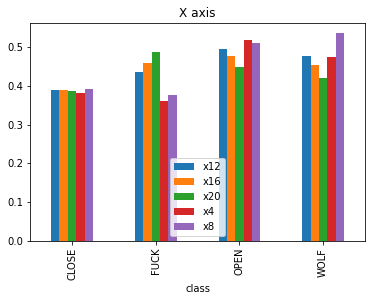

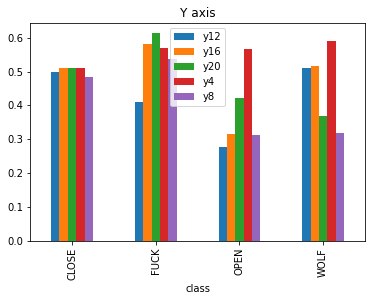

In [5]:
# Hand Model Visualization
df_pivot_x = pd.pivot_table(
    df, 
    values=["x4", "x8", "x12", "x16", "x20"],
    index="class", 
    aggfunc=np.mean
)
df_pivot_y = pd.pivot_table(
    df, 
    values=["y4", "y8", "y12", "y16", "y20"],
    index="class", 
    aggfunc=np.mean
)
plt.figure(figsize=(10,10))
df_pivot_x.plot(kind="bar", title="X axis")
df_pivot_y.plot(kind="bar", title="Y axis")



In [6]:
# Encode the class
le = LabelEncoder()
le.fit(df['class'])
df['class_encoded'] = le.transform(df['class'])

X = df.drop(['class', 'class_encoded'], axis=1)
y = df['class_encoded']

In [7]:
# Divide it to train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1234)
X_train.shape, X_test.shape

((3646, 63), (1563, 63))

In [8]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Neural Network Design with PyTorch

## Creating train and test datasets

In [36]:
class BodyLanguageDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [37]:
train_dataset = BodyLanguageDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_dataset = BodyLanguageDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Modeling

In [38]:
class BodyLanguageClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(BodyLanguageClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
        

In [39]:
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = max(y) + 1

model = BodyLanguageClassification(num_feature = NUM_FEATURES, num_class = NUM_CLASSES)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

BodyLanguageClassification(
  (layer_1): Linear(in_features=63, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the Model

In [40]:
# accuracy function
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [41]:
# storage of stats
accuracy_stats = {
    'train': []
}
loss_stats = {
    'train': []
}

In [42]:
# Training
for e in range(EPOCHS):

    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))

    if e%10==0:
        print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

Epoch 0: | Train Loss: 0.22804 | Train Acc: 96.285
Epoch 10: | Train Loss: 0.00185 | Train Acc: 100.000
Epoch 20: | Train Loss: 0.00785 | Train Acc: 99.785
Epoch 30: | Train Loss: 0.00037 | Train Acc: 100.000
Epoch 40: | Train Loss: 0.00009 | Train Acc: 100.000
Epoch 50: | Train Loss: 0.00059 | Train Acc: 100.000
Epoch 60: | Train Loss: 0.00387 | Train Acc: 99.842
Epoch 70: | Train Loss: 0.00011 | Train Acc: 100.000
Epoch 80: | Train Loss: 0.01844 | Train Acc: 99.711
Epoch 90: | Train Loss: 0.00007 | Train Acc: 100.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

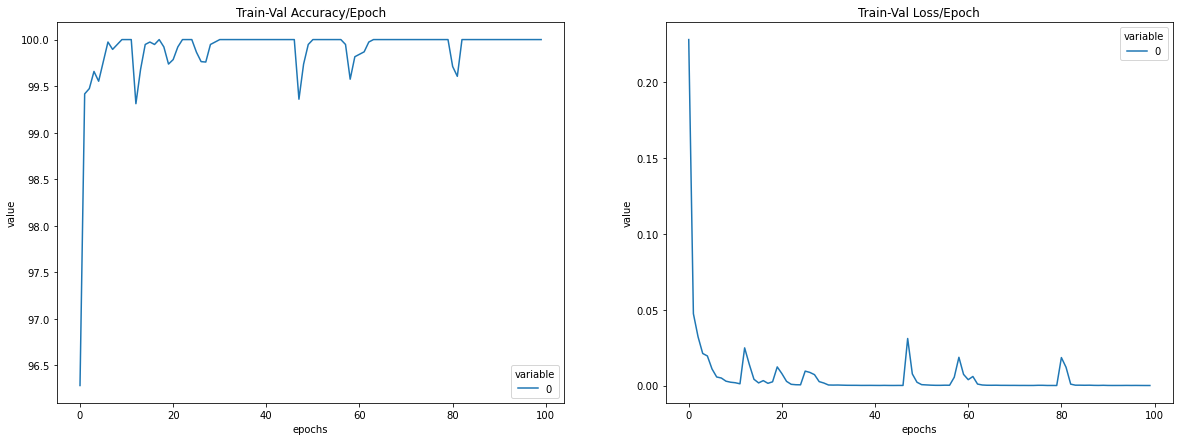

In [43]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats['train']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats['train']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Prediction and Evaluation

In [44]:
y_pred_list = []
with torch.no_grad():
    test_loss=0
    test_acc=0
    model.eval()
    for X_batch, Y_batch in test_loader:
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

        test_it_loss = criterion(y_test_pred, Y_batch)
        test_it_acc = multi_acc(y_test_pred, Y_batch)
        
        test_loss += test_it_loss.item()
        test_acc += test_it_acc.item()

    loss_stats['test'] = (test_loss/len(test_loader))
    accuracy_stats['test'] = (test_acc/len(test_loader))
        

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

loss_stats['test'], accuracy_stats['test']

(0.011906760523006609, 99.8080614203455)

In [45]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       0.99      1.00      0.99       295
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00       278

    accuracy                           1.00      1563
   macro avg       1.00      1.00      1.00      1563
weighted avg       1.00      1.00      1.00      1563



## Live Detection

In [46]:
mp_drawing = mp.solutions.drawing_utils # Drawing helper
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic

### Holistic Model

In [ ]:
import traceback
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
        # Export coordinates
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row
            
            # Make Detections
            X = pd.DataFrame([row])
            #X = scaler.fit_transform(X)
            X = np.array(X)

            # mylist.append(list(*X))
            # if(counter %  50 == 0):
            #     print('saving')
            #     a = np.array(mylist)
            #     np.savetxt("foo1.csv", a, delimiter=",")
            # print(counter)
            X = torch.tensor(X, dtype=torch.float32)

            with torch.no_grad():
                model.eval()
                y_test_pred = model(X)
                _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]
                #print(body_language_class)
            
            # Grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [640,480]).astype(int))
            
            cv2.rectangle(image, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(body_language_class)*20, coords[1]-30), 
                          (245, 117, 16), -1)
            cv2.putText(image, body_language_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # # Display Probability
            # cv2.putText(image, 'PROB'
            #             , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            # cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
            #             , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            traceback.print_exc()
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


### Hand Model

In [47]:
import traceback

cap = cv2.VideoCapture(0)
# Initiate Hand model
with mp_hands.Hands(max_num_hands=1) as hand:

    while cap.isOpened():
        ret, frame = cap.read()

        # Recolor the image
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = hand.process(image)

        # Landmark detection
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, handLms, mp_hands.HAND_CONNECTIONS)

        if results.multi_hand_landmarks:
            # Export coordinates
            try:
                # Extracting hand landmarks
                # Extracting pose landmark
                detected_hand = results.multi_hand_landmarks[0].landmark
                hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in detected_hand]).flatten())
                #print(list([landmark for landmark in detected_hand]))

                # Concatanate rows
                row = hand_row

                # Make Detections
                X = pd.DataFrame([row])
                #X = scaler.fit_transform(X)
                X = np.array(X)

                # mylist.append(list(*X))
                # if(counter %  50 == 0):
                #     print('saving')
                #     a = np.array(mylist)
                #     np.savetxt("foo1.csv", a, delimiter=",")
                # print(counter)
                X = torch.tensor(X, dtype=torch.float32)

                with torch.no_grad():
                    model.eval()
                    y_test_pred = model(X)
                    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                    body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]

                # Get status box
                cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)

                # Display Class
                cv2.putText(image, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                
            except:
                traceback.print_exc()
                            
            cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()